# Preparation

In [1]:
use_colab = True
if use_colab:
    !pip install transformers[sentencepiece]
    from google.colab import drive
    drive.mount('/content/drive')
    path = "/content/drive/MyDrive/CAPP30255_Project/twitter_disaster_detection"


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 38.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.20.2 which is incompatible.
tenso

Mounted at /content/drive


In [2]:
import os
import copy
import pandas as pd
import numpy as np
# from tqdm.autonotebook import tqdm
from tqdm import tqdm
import random
import json

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold

# importing HuggingFace transformers library
import transformers
from transformers import pipeline, get_linear_schedule_with_warmup

print("Transformer version:", transformers.__version__)
print("torch.device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Transformer version: 4.29.2
torch.device: cuda


In [3]:
data = pd.read_csv(path+'/data/cleaned-train-tweets.csv', sep="|")
display(data.sample(5))


,id,keyword,location,text,target,clean_text
13246,13246,flooding,Jakarta/Kuala Lumpur/S'pore,Heavy Rainfall and Flooding in Northern #VietN...,1,heavy rainfall flooding northern vietnam situa...
16688,16688,structural%20failure,NaN,Investigators say a fatal Virgin Galactic spac...,1,investigator say fatal virgin galactic spacesh...
3745,3745,fire,NaN,My asshole is on fire https://t.co/Y3FO0gHg8t,0,asshole fire http
14069,14069,injured,Nigeria,Ogun smugglers engage Customs in shootoutåÊ: S...,1,ogun smuggler engage custom shootoutåê several...
3301,3301,evacuate,NaN,Condemnation clearly replacing the latest resp...,1,condemnation clearly replacing latest response...


# BERT without fine-tuning

In [ ]:
simple_model = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

In [ ]:
labels = ["not disaster", "disaster"]

def model_simple_test(i):
    """
    Performs a simple test of the simple_model by predicting the label for a specific index of the input data.

    Args:
        i (int): The index of the data to test.

    Returns:
        None
    """
    responce= simple_model(
        data["text"][i],
        candidate_labels=labels
    )
    print(responce)

    true_label = labels[1] if data["target"][i] else labels[0]
    print("True Label:", true_label)
    print("Prediction:", responce["labels"][np.argmax(responce["scores"])])

def calculate_accuracy_zscppl(data, target_ids):
    """
    Calculates the accuracy of the simple_model on a subset of data specified by target_ids.

    Args:
        data (dict): The input data.
        target_ids (list): A list of indices indicating the subset of data to calculate accuracy on.

    Returns:
        accuracy (float): The accuracy of the model on the specified subset of data.
    """
    accurate_num = 0
    for i in target_ids:
        response = simple_model(
            data["text"][i],
            candidate_labels=labels
        )
        true_label = labels[1] if data["target"][i] else labels[0]
        if true_label == response["labels"][np.argmax(response["scores"])]:
            accurate_num += 1
    return accurate_num / len(target_ids)


In [ ]:
data_sample = data.sample(5)
data_sample_ids = data_sample["id"].tolist()
display(data_sample)

for id in data_sample_ids:
    model_simple_test(id)

,id,keyword,location,text,target,clean_text
3782,3782,fire%20truck,District 12 - Orange County,SIGALERT UPDATE #3***N-133 CLOSED AT 5 FWY UFN...,1,sigalert update closed fwy ufn trash truck fire
9491,9491,burning,NaN,@aubilenon @MarkKriegsman if you think you'd l...,0,aubilenon markkriegsman think like burning man...
8573,8573,blaze,Delhi,#socialmedia news - New Facebook Page Features...,0,socialmedia news new facebook page feature see...
9514,9514,burning,"TÌÁchira, Venezuela",the Burning Legion has returned,0,burning legion returned
14290,14290,landslide,NaN,5 need to-dos seeing as how technical writing ...,0,need seeing technical writing administer apps ...


{'sequence': 'SIGALERT UPDATE #3***N-133 CLOSED AT 5 FWY UFN***- TRASH TRUCK FIRE', 'labels': ['disaster', 'not disaster'], 'scores': [0.9129602909088135, 0.08703970164060593]}
True Label: disaster
Prediction: disaster
{'sequence': "@aubilenon @MarkKriegsman if you think you'd like burning man you should try it because it's the only way to know!", 'labels': ['disaster', 'not disaster'], 'scores': [0.7511258721351624, 0.24887412786483765]}
True Label: not disaster
Prediction: disaster
{'sequence': '#socialmedia news - New Facebook Page Features Seek to Help Personalize the Customer Experience http://t.co/nbizaTlsmV', 'labels': ['not disaster', 'disaster'], 'scores': [0.9289625883102417, 0.07103737443685532]}
True Label: not disaster
Prediction: not disaster
{'sequence': 'the Burning Legion has returned', 'labels': ['disaster', 'not disaster'], 'scores': [0.9670848250389099, 0.0329151451587677]}
True Label: not disaster
Prediction: disaster
{'sequence': '5 need to-dos seeing as how techn

In [ ]:
num_target = 50
target_ids = [random.randint(0, len(data)) for _ in range(num_target)]
accuracy_rate = calculate_accuracy_zscppl(data, target_ids)
print(f"Accuracy Rate using Pretrained BERT Zero-Shot-Classification: {accuracy_rate}")


Accuracy Rate using Pretrained BERT Zero-Shot-Classification: 0.6


# DistilBERT model with fine-tuning

## Preparation

### Building A PyTorch Dataset

The following code uses the idea from this tutorial [Fine-tuning with custom datasets](https://huggingface.co/transformers/v3.2.0/custom_datasets.html) on building a custom dataset:


In [4]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer, mode="train", max_length=None):
        """
        A custom PyTorch dataset for handling tweet data.

        Args:
            dataframe: The input dataframe containing tweet data.
            tokenizer: The tokenizer object used to tokenize the tweets.
            mode (str): The mode of the dataset (default is "train").
            max_length (int): The maximum length of the tokenized sequences (default is None).
        """
        self.dataframe = dataframe
        self.mode = mode
        if mode != "test":
            self.targets = dataframe['target'].values
        texts = list(dataframe['text'].values)
        self.encodings = tokenizer(texts, 
                                   padding=True, 
                                   truncation=True, 
                                   max_length=max_length)


    def __getitem__(self, idx):
        """
        Retrieves the item at the given index from the dataset.

        Args:
            idx (int): The index of the item to retrieve.

        Returns:
            item (dict): A dictionary containing the input IDs, attention masks, and labels (if available) of the item.
        """
        item = {}
        for key, values in self.encodings.items():
            item[key] = torch.tensor(values[idx])

        if self.mode != "test":
            item['labels'] = torch.tensor(self.targets[idx])
        return item


    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            length (int): The length of the dataset.
        """
        return len(self.dataframe)


def make_loaders(dataframe, tokenizer, mode="train", max_length=None):
    """
    Creates data loaders for the tweet dataset.

    Args:
        dataframe: The input dataframe containing tweet data.
        tokenizer: The tokenizer object used to tokenize the tweets.
        mode (str): The mode of the dataset (default is "train").
        max_length (int): The maximum length of the tokenized sequences (default is None).

    Returns:
        dataloader (torch.utils.data.DataLoader): The data loader for the tweet dataset.
    """
    dataset = TweetDataset(dataframe, tokenizer, mode, max_length=max_length)
    dataloader = torch.utils.data.DataLoader(dataset, 
                                             batch_size=parameters.batch_size, 
                                             shuffle=True if mode == "train" else False,
                                             num_workers=parameters.num_workers)
    return dataloader


### Construction of DistilBERT

In [6]:
class CustomModel(nn.Module):
    def __init__(self,
                 bert_model,
                 num_labels, 
                 bert_hidden_dim=768, 
                 classifier_hidden_dim=768, 
                 dropout=None):
        """
        Initializes an instance of the CustomModel class. It takes the following arguments:
        Args: 
          bert_model: 
            The pre-trained BERT model to be used as the base model.
          num_labels:
            The number of output labels for classification.
          bert_hidden_dim:
            The dimensionality of the hidden states in the BERT model 
            (default is 768).
          classifier_hidden_dim:
            The dimensionality of the hidden states in the classifier layers 
            (default is 768).
          dropout: 
            The dropout probability to be applied in the classifier layers 
            (default is None). If it is None, dropout is not applied.
        """

        super().__init__()
        self.bert_model = bert_model
        if not dropout:
            self.head = nn.Sequential(nn.Linear(bert_hidden_dim, classifier_hidden_dim),
                                      nn.ReLU(),
                                      nn.Dropout(dropout),
                                      nn.Linear(classifier_hidden_dim, num_labels))
        else:
            self.head = nn.Sequential(nn.Linear(bert_hidden_dim, classifier_hidden_dim),
                                      nn.ReLU(),
                                      nn.Identity(),
                                      nn.Linear(classifier_hidden_dim, num_labels))

    def forward(self, batch):
        output = self.bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
        CLS_token_state = output.last_hidden_state[:, 0, :]
        return self.head(CLS_token_state)


## Training and Evaluation

In [7]:
class AverageCalculator:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        """
        Reset the calculator by setting the average, sum, and count values to zero.
        """
        self.avg, self.sum, self.count = [0]*3

    def update(self, val, count=1):
        """
        Update the calculator with a new value.

        Parameters:
            val (float): The new value to be added.
            count (int, optional): The number of instances the value represents (default is 1).
        """
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        """
        Return a string representation of the calculator object.

        Returns:
            str: A string displaying the name of the metric and its average value rounded to four decimal places.
        """
        text = f"{self.name}: {self.avg:.4f}"
        return text


def one_epoch(model, criterion, loader, device, optimizer=None,
              lr_scheduler=None, mode="train", step="batch"):
    """
    Executes one epoch of training or evaluation for a given model.

    Args:
        model (nn.Module): The model to be trained or evaluated.
        criterion: The loss function used for training or evaluation.
        loader: The data loader containing the input data.
        device: The device (CPU or GPU) to be used for computation.
        optimizer: The optimizer used for training. Default is None.
        lr_scheduler: The learning rate scheduler. Default is None.
        mode (str): The mode of operation. Can be "train" or "eval". Default is "train".
        step (str): The step size for the learning rate scheduler. Can be "batch" or "epoch". Default is "batch".

    Returns:
        Tuple: A tuple containing the average loss and accuracy calculated during the epoch.
    """
    loss_calculator = AverageCalculator()
    accuracy_calculator = AverageCalculator()
    
    tqdm_object = tqdm(loader, total=len(loader))
    for batch in tqdm_object:
        batch = {}
        for k, v in batch.items():
            batch[k] = v.to(device)
        preds = model(batch)
        loss = criterion(preds, batch['labels'])
        if mode == "train":
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if step == "batch":
                lr_scheduler.step()
                
        count = batch['input_ids'].size(0)
        loss_calculator.update(loss.item(), count)

        accuracy = get_accuracy(preds.detach(), batch['labels'])
        accuracy_calculator.update(accuracy.item(), count)
        if mode == "train":
            tqdm_object.set_postfix(loss=loss_calculator.avg,
                                    accuracy=accuracy_calculator.avg,
                                    lr=get_lr(optimizer))
        else:
            tqdm_object.set_postfix(loss=loss_calculator.avg,
                                    accuracy=accuracy_calculator.avg)
    
    return loss_calculator, accuracy_calculator

def get_lr(optimizer):
    """
    Returns the current learning rate of the optimizer.

    Args:
        optimizer: The optimizer.

    Returns:
        float: The current learning rate.
    """
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def get_accuracy(preds, targets):
    """
    Calculates the accuracy given the predicted and target labels.

    Args:
        preds (torch.Tensor): The predicted labels. Shape: (batch_size, num_labels)
        targets (torch.Tensor): The target labels. Shape: (batch_size)

    Returns:
        torch.Tensor: The accuracy value.
    """
    preds = preds.argmax(dim=1)
    acc = (preds == targets).float().mean()
    return acc


In [8]:
def train_eval(num_epochs, model, train_loader, valid_loader,
               criterion, optimizer, device, parameters, loss_accuracy, lr_scheduler=None):
    """
    Train and evaluate the model for a specified number of epochs.

    Args:
        num_epochs (int): The number of epochs to train.
        model (nn.Module): The model to train and evaluate.
        train_loader (DataLoader): The data loader for training data.
        valid_loader (DataLoader): The data loader for validation data.
        criterion: The loss function.
        optimizer: The optimizer for updating model parameters.
        device: The device to run the model on.
        parameters: Additional parameters for training and evaluation.
        loss_accuracy (dict): A dictionary to store the loss and accuracy values.
        lr_scheduler: The learning rate scheduler (default: None).

    Returns:
        None
    """

    best_loss = float('inf')
    best_model_weights = copy.deepcopy(model.state_dict())

    # Loop over the specified number of epochs
    for epoch in range(num_epochs):
        print("~" * 30)
        print(f"Epoch {epoch + 1}")
        current_lr = get_lr(optimizer)

        # Set the model in training mode
        model.train()
        # Perform one epoch of training
        train_loss, train_acc = one_epoch(model,
                                          criterion,
                                          train_loader,
                                          device,
                                          optimizer=optimizer,
                                          lr_scheduler=lr_scheduler,
                                          mode="train",
                                          step=parameters.step)

        model.eval()
        with torch.no_grad():
            valid_loss, valid_acc = one_epoch(model,
                                              criterion,
                                              valid_loader,
                                              device,
                                              optimizer=None,
                                              lr_scheduler=None,
                                              mode="valid")

        # Check if the current validation loss is better than the best loss so far
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            best_model_weights = copy.deepcopy(model.state_dict())
            print("Saving the best model!")
            torch.save(model.state_dict(),
                       f'{parameters.model_path}/{parameters.model_save_name}')

        # Update learning rate if lr_scheduler is ReduceLROnPlateau
        if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            lr_scheduler.step(valid_loss.avg)

            # If the learning rate has changed, reload the previous best model weights
            if current_lr != get_lr(optimizer):
                print("Loading the best model weights!")
                model.load_state_dict(torch.load(f'{parameters.model_path}/{parameters.model_save_name}',
                                                 map_location=device))

        print(f"Train Loss: {train_loss.avg:.5f}")
        print(f"Train Accuracy: {train_acc.avg:.5f}")

        print(f"Valid Loss: {valid_loss.avg:.5f}")
        print(f"Valid Accuracy: {valid_acc.avg:.5f}")
        print("*" * 30)

        # Store loss and accuracy values in the provided dictionary
        loss_accuracy["Train Loss"].append(train_loss.avg)
        loss_accuracy["Train Accuracy"].append(train_acc.avg)
        loss_accuracy["Valid Loss"].append(valid_loss.avg)
        loss_accuracy["Valid Accuracy"].append(valid_acc.avg)


### K-Fold Cross Validation

In [9]:
from sklearn.model_selection import KFold
import pandas as pd

def create_folds(data, num_folds=5):
    """
    Create fold column in the dataframe for cross-validation.

    Args:
        data (pandas.DataFrame): The dataframe.
        num_folds (int, optional): Number of folds to create (default is 5).

    Returns:
        pandas.DataFrame: The dataframe with the fold column added.
    """
    # Create an instance of KFold class and split the data
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    for fold_index, (_, valid_index) in enumerate(kfold.split(X=data['id'])):
        # Update the fold column in the dataframe using the valid indices
        data.loc[valid_index, 'fold'] = fold_index
    return data


In [10]:
def one_fold(fold, parameters):  
    """
    Perform training for a single fold of the dataset.

    Args:
        fold (int): The fold number.
        parameters: An object containing various parameters and configurations.

    Returns:
        None
    """
    print(f"Training Fold: {fold}")
    loss_accuracy = {"Train Loss": [], "Train Accuracy": [], "Valid Loss": [], "Valid Accuracy": []}

    # Load pre-trained BERT model
    bert_model = transformers.DistilBertModel.from_pretrained(parameters.model_name)
    tokenizer = transformers.AutoTokenizer.from_pretrained(parameters.model_name, use_fast=True)
    
    # Read the cleaned training tweets data
    dataframe = pd.read_csv(path+'/data/cleaned-train-tweets.csv', sep="|")
    # Create folds in the dataframe for cross-validation
    dataframe = create_folds(dataframe, n_splits=parameters.n_folds)
    train_dataframe = dataframe[dataframe['fold'] != fold].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe['fold'] == fold].reset_index(drop=True)

    # Create data loaders for training and validation datasets
    train_loader = make_loaders(train_dataframe, 
                                tokenizer, 
                                "train", 
                                parameters.max_length)
    valid_loader = make_loaders(valid_dataframe, 
                                tokenizer, 
                                "valid", 
                                parameters.max_length)

    # Set device (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Create custom model using the BERT model
    model = CustomModel(bert_model, parameters.num_labels, dropout=parameters.dropout).to(device)
    # Define the optimizer for model parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=parameters.learning_rate)
    
    # Set the learning rate scheduler based on the specified parameters
    if parameters.scheduler == "ReduceLROnPlateau":
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                                  mode="min", 
                                                                  factor=0.5, 
                                                                  patience=parameters.patience)

        parameters.step = "epoch"
        
    elif parameters.scheduler == "LinearWarmup":
        num_train_steps = len(train_loader) * parameters.epochs
        lr_scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                       num_warmup_steps=0, 
                                                       num_training_steps=num_train_steps)
        
        # Specify when to step the scheduler: after an epoch or after a batch
        parameters.step = "batch"
    
    # Define the loss criterion
    criterion = nn.CrossEntropyLoss()
    parameters.model_save_name = f"model_fold_{fold}.pt"
    # Perform the training and evaluation
    train_eval(parameters.epochs, model, train_loader, valid_loader,
               criterion, optimizer, device, parameters, loss_accuracy, lr_scheduler=lr_scheduler)

    # Uncomment the code below if you want to save the loss and accuracy as a JSON file
    # tf = open(f"{path}/models/loss_accuracy_{fold}.json", "x")
    # json.dump(loss_accuracy, tf)
    # tf.close()


In [11]:
def train_folds(parameters):
    """
    Perform training for all folds of the dataset.

    Args:
        parameters: An object containing various parameters and configurations.

    Returns:
        None
    """
    n_folds = parameters.n_folds
    for i in range(n_folds):
        # Train and evaluate for each fold
        one_fold(fold=i, parameters=parameters)


## Tuning

In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 32
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3
parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 193/193 [00:15<00:00, 12.20it/s, accuracy=0.861, loss=0.369]


Saved best model!
Train Loss: 0.39624
Train Accuracy: 0.83484
Valid Loss: 0.36893
Valid Accuracy: 0.86148
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 193/193 [00:15<00:00, 12.46it/s, accuracy=0.884, loss=0.299]


Saved best model!
Train Loss: 0.26632
Train Accuracy: 0.90085
Valid Loss: 0.29943
Valid Accuracy: 0.88373
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 193/193 [00:15<00:00, 12.46it/s, accuracy=0.9, loss=0.299]


Saved best model!
Train Loss: 0.16299
Train Accuracy: 0.94113
Valid Loss: 0.29887
Valid Accuracy: 0.89964
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 193/193 [00:15<00:00, 12.45it/s, accuracy=0.87, loss=0.335]


Saved best model!
Train Loss: 0.41373
Train Accuracy: 0.82038
Valid Loss: 0.33518
Valid Accuracy: 0.86976
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 193/193 [00:15<00:00, 12.42it/s, accuracy=0.878, loss=0.313]


Saved best model!
Train Loss: 0.27293
Train Accuracy: 0.89557
Valid Loss: 0.31261
Valid Accuracy: 0.87804
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 193/193 [00:15<00:00, 12.23it/s, accuracy=0.893, loss=0.311]


Saved best model!
Train Loss: 0.16510
Train Accuracy: 0.94365
Valid Loss: 0.31143
Valid Accuracy: 0.89282
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 193/193 [00:15<00:00, 12.09it/s, accuracy=0.86, loss=0.339]


Saved best model!
Train Loss: 0.39955
Train Accuracy: 0.82770
Valid Loss: 0.33870
Valid Accuracy: 0.86016
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 193/193 [00:15<00:00, 12.18it/s, accuracy=0.897, loss=0.278]


Saved best model!
Train Loss: 0.26119
Train Accuracy: 0.90159
Valid Loss: 0.27786
Valid Accuracy: 0.89654
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 193/193 [00:15<00:00, 12.18it/s, accuracy=0.888, loss=0.311]


Train Loss: 0.15444
Train Accuracy: 0.94251
Valid Loss: 0.31078
Valid Accuracy: 0.88793
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3
parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.80it/s, accuracy=0.859, loss=0.347]


Saved best model!
Train Loss: 0.40761
Train Accuracy: 0.82485
Valid Loss: 0.34736
Valid Accuracy: 0.85905
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.76it/s, accuracy=0.872, loss=0.318]


Saved best model!
Train Loss: 0.28239
Train Accuracy: 0.89346
Valid Loss: 0.31829
Valid Accuracy: 0.87187
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.78it/s, accuracy=0.888, loss=0.313]


Saved best model!
Train Loss: 0.19137
Train Accuracy: 0.93017
Valid Loss: 0.31318
Valid Accuracy: 0.88828
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.75it/s, accuracy=0.86, loss=0.346]


Saved best model!
Train Loss: 0.41810
Train Accuracy: 0.81697
Valid Loss: 0.34594
Valid Accuracy: 0.85986
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.885, loss=0.305]


Saved best model!
Train Loss: 0.28280
Train Accuracy: 0.89306
Valid Loss: 0.30509
Valid Accuracy: 0.88503
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.78it/s, accuracy=0.892, loss=0.315]


Train Loss: 0.18823
Train Accuracy: 0.93479
Valid Loss: 0.31475
Valid Accuracy: 0.89185
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.66it/s, accuracy=0.859, loss=0.35]


Saved best model!
Train Loss: 0.41384
Train Accuracy: 0.82113
Valid Loss: 0.35003
Valid Accuracy: 0.85870
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.61it/s, accuracy=0.885, loss=0.309]


Saved best model!
Train Loss: 0.28655
Train Accuracy: 0.89112
Valid Loss: 0.30893
Valid Accuracy: 0.88485
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.69it/s, accuracy=0.899, loss=0.279]


Saved best model!
Train Loss: 0.19258
Train Accuracy: 0.93245
Valid Loss: 0.27942
Valid Accuracy: 0.89881
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 128
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3
parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 49/49 [00:14<00:00,  3.31it/s, accuracy=0.857, loss=0.359]


Saved best model!
Train Loss: 0.43871
Train Accuracy: 0.80666
Valid Loss: 0.35905
Valid Accuracy: 0.85661
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 49/49 [00:14<00:00,  3.27it/s, accuracy=0.87, loss=0.329]


Saved best model!
Train Loss: 0.30734
Train Accuracy: 0.88331
Valid Loss: 0.32878
Valid Accuracy: 0.87009
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 49/49 [00:14<00:00,  3.30it/s, accuracy=0.891, loss=0.307]


Saved best model!
Train Loss: 0.22275
Train Accuracy: 0.92140
Valid Loss: 0.30688
Valid Accuracy: 0.89071
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 49/49 [00:14<00:00,  3.28it/s, accuracy=0.854, loss=0.363]


Saved best model!
Train Loss: 0.43164
Train Accuracy: 0.81202
Valid Loss: 0.36299
Valid Accuracy: 0.85450
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 49/49 [00:15<00:00,  3.26it/s, accuracy=0.872, loss=0.339]


Saved best model!
Train Loss: 0.30695
Train Accuracy: 0.87795
Valid Loss: 0.33933
Valid Accuracy: 0.87204
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 49/49 [00:14<00:00,  3.28it/s, accuracy=0.883, loss=0.333]


Saved best model!
Train Loss: 0.22383
Train Accuracy: 0.92018
Valid Loss: 0.33326
Valid Accuracy: 0.88308
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 49/49 [00:14<00:00,  3.35it/s, accuracy=0.857, loss=0.351]


Saved best model!
Train Loss: 0.44064
Train Accuracy: 0.80627
Valid Loss: 0.35106
Valid Accuracy: 0.85724
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 49/49 [00:14<00:00,  3.38it/s, accuracy=0.876, loss=0.314]


Saved best model!
Train Loss: 0.31060
Train Accuracy: 0.88154
Valid Loss: 0.31368
Valid Accuracy: 0.87559
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 49/49 [00:14<00:00,  3.38it/s, accuracy=0.888, loss=0.297]


Saved best model!
Train Loss: 0.23450
Train Accuracy: 0.91702
Valid Loss: 0.29747
Valid Accuracy: 0.88761
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.73it/s, accuracy=0.851, loss=0.357]


Saved best model!
Train Loss: 0.40899
Train Accuracy: 0.82639
Valid Loss: 0.35676
Valid Accuracy: 0.85060
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.867, loss=0.34]


Saved best model!
Train Loss: 0.28516
Train Accuracy: 0.89143
Valid Loss: 0.33968
Valid Accuracy: 0.86716
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.887, loss=0.309]


Saved best model!
Train Loss: 0.18873
Train Accuracy: 0.93179
Valid Loss: 0.30920
Valid Accuracy: 0.88714
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.70it/s, accuracy=0.868, loss=0.34]


Saved best model!
Train Loss: 0.41588
Train Accuracy: 0.81900
Valid Loss: 0.34047
Valid Accuracy: 0.86765
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.76it/s, accuracy=0.887, loss=0.309]


Saved best model!
Train Loss: 0.27804
Train Accuracy: 0.89476
Valid Loss: 0.30867
Valid Accuracy: 0.88665
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.904, loss=0.285]


Saved best model!
Train Loss: 0.18642
Train Accuracy: 0.93366
Valid Loss: 0.28461
Valid Accuracy: 0.90419
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.67it/s, accuracy=0.863, loss=0.339]


Saved best model!
Train Loss: 0.41302
Train Accuracy: 0.81926
Valid Loss: 0.33852
Valid Accuracy: 0.86292
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.63it/s, accuracy=0.887, loss=0.307]


Saved best model!
Train Loss: 0.28063
Train Accuracy: 0.89290
Valid Loss: 0.30682
Valid Accuracy: 0.88696
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.67it/s, accuracy=0.901, loss=0.279]


Saved best model!
Train Loss: 0.18279
Train Accuracy: 0.93513
Valid Loss: 0.27861
Valid Accuracy: 0.90141
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 4
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.78it/s, accuracy=0.848, loss=0.373]


Saved best model!
Train Loss: 0.41296
Train Accuracy: 0.81746
Valid Loss: 0.37315
Valid Accuracy: 0.84784
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.73it/s, accuracy=0.873, loss=0.312]


Saved best model!
Train Loss: 0.27979
Train Accuracy: 0.89557
Valid Loss: 0.31200
Valid Accuracy: 0.87301
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.77it/s, accuracy=0.897, loss=0.296]


Saved best model!
Train Loss: 0.18627
Train Accuracy: 0.93350
Valid Loss: 0.29639
Valid Accuracy: 0.89704
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.69it/s, accuracy=0.867, loss=0.339]


Saved best model!
Train Loss: 0.40715
Train Accuracy: 0.82306
Valid Loss: 0.33856
Valid Accuracy: 0.86749
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.76it/s, accuracy=0.89, loss=0.293]


Saved best model!
Train Loss: 0.28229
Train Accuracy: 0.89306
Valid Loss: 0.29268
Valid Accuracy: 0.88990
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.74it/s, accuracy=0.898, loss=0.276]


Saved best model!
Train Loss: 0.18892
Train Accuracy: 0.93471
Valid Loss: 0.27601
Valid Accuracy: 0.89818
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.62it/s, accuracy=0.861, loss=0.349]


Saved best model!
Train Loss: 0.41310
Train Accuracy: 0.82243
Valid Loss: 0.34871
Valid Accuracy: 0.86097
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.68it/s, accuracy=0.879, loss=0.312]


Saved best model!
Train Loss: 0.28591
Train Accuracy: 0.89217
Valid Loss: 0.31213
Valid Accuracy: 0.87900
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.65it/s, accuracy=0.902, loss=0.268]


Saved best model!
Train Loss: 0.19294
Train Accuracy: 0.93204
Valid Loss: 0.26834
Valid Accuracy: 0.90239
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 164
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 8
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 38/38 [00:14<00:00,  2.67it/s, accuracy=0.851, loss=0.366]


Saved best model!
Train Loss: 0.43580
Train Accuracy: 0.81267
Valid Loss: 0.36562
Valid Accuracy: 0.85125
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 38/38 [00:14<00:00,  2.65it/s, accuracy=0.865, loss=0.34]


Saved best model!
Train Loss: 0.31400
Train Accuracy: 0.88112
Valid Loss: 0.33951
Valid Accuracy: 0.86505
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 38/38 [00:14<00:00,  2.66it/s, accuracy=0.882, loss=0.319]


Saved best model!
Train Loss: 0.23828
Train Accuracy: 0.91539
Valid Loss: 0.31860
Valid Accuracy: 0.88178
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 38/38 [00:14<00:00,  2.64it/s, accuracy=0.861, loss=0.351]


Saved best model!
Train Loss: 0.44344
Train Accuracy: 0.80641
Valid Loss: 0.35062
Valid Accuracy: 0.86148
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 38/38 [00:14<00:00,  2.64it/s, accuracy=0.879, loss=0.324]


Saved best model!
Train Loss: 0.31884
Train Accuracy: 0.87568
Valid Loss: 0.32432
Valid Accuracy: 0.87934
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 38/38 [00:14<00:00,  2.66it/s, accuracy=0.877, loss=0.328]


Train Loss: 0.24363
Train Accuracy: 0.90905
Valid Loss: 0.32769
Valid Accuracy: 0.87675
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 38/38 [00:13<00:00,  2.83it/s, accuracy=0.859, loss=0.352]


Saved best model!
Train Loss: 0.43805
Train Accuracy: 0.81098
Valid Loss: 0.35230
Valid Accuracy: 0.85886
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 38/38 [00:13<00:00,  2.82it/s, accuracy=0.879, loss=0.314]


Saved best model!
Train Loss: 0.31595
Train Accuracy: 0.87886
Valid Loss: 0.31393
Valid Accuracy: 0.87884
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 38/38 [00:13<00:00,  2.79it/s, accuracy=0.89, loss=0.3]


Saved best model!
Train Loss: 0.24200
Train Accuracy: 0.91288
Valid Loss: 0.30004
Valid Accuracy: 0.89037
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-4
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.841, loss=0.377]


Saved best model!
Train Loss: 0.42777
Train Accuracy: 0.82063
Valid Loss: 0.37685
Valid Accuracy: 0.84053
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.76it/s, accuracy=0.866, loss=0.384]


Train Loss: 0.27810
Train Accuracy: 0.89866
Valid Loss: 0.38411
Valid Accuracy: 0.86635
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.89it/s, accuracy=0.568, loss=0.685]


Train Loss: 0.31086
Train Accuracy: 0.85708
Valid Loss: 0.68475
Valid Accuracy: 0.56804
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.75it/s, accuracy=0.842, loss=0.387]


Saved best model!
Train Loss: 0.44846
Train Accuracy: 0.80828
Valid Loss: 0.38718
Valid Accuracy: 0.84167
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.868, loss=0.369]


Saved best model!
Train Loss: 0.30358
Train Accuracy: 0.89151
Valid Loss: 0.36917
Valid Accuracy: 0.86798
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.85it/s, accuracy=0.86, loss=0.371]


Train Loss: 0.28907
Train Accuracy: 0.89923
Valid Loss: 0.37125
Valid Accuracy: 0.85969
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.75it/s, accuracy=0.86, loss=0.35]


Saved best model!
Train Loss: 0.44255
Train Accuracy: 0.81049
Valid Loss: 0.35021
Valid Accuracy: 0.85983
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.77it/s, accuracy=0.883, loss=0.351]


Train Loss: 0.26450
Train Accuracy: 0.90435
Valid Loss: 0.35081
Valid Accuracy: 0.88306
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.86it/s, accuracy=0.797, loss=0.539]


Train Loss: 0.18266
Train Accuracy: 0.94186
Valid Loss: 0.53891
Valid Accuracy: 0.79682
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.74it/s, accuracy=0.855, loss=0.354]


Saved best model!
Train Loss: 0.40745
Train Accuracy: 0.82818
Valid Loss: 0.35389
Valid Accuracy: 0.85515
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.75it/s, accuracy=0.87, loss=0.33]


Saved best model!
Train Loss: 0.28069
Train Accuracy: 0.89411
Valid Loss: 0.32966
Valid Accuracy: 0.87025
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.891, loss=0.311]


Saved best model!
Train Loss: 0.18392
Train Accuracy: 0.93374
Valid Loss: 0.31124
Valid Accuracy: 0.89136
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.72it/s, accuracy=0.869, loss=0.336]


Saved best model!
Train Loss: 0.41840
Train Accuracy: 0.81445
Valid Loss: 0.33602
Valid Accuracy: 0.86928
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.76it/s, accuracy=0.89, loss=0.302]


Saved best model!
Train Loss: 0.28258
Train Accuracy: 0.89265
Valid Loss: 0.30174
Valid Accuracy: 0.89006
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.77it/s, accuracy=0.9, loss=0.274]


Saved best model!
Train Loss: 0.18427
Train Accuracy: 0.93723
Valid Loss: 0.27359
Valid Accuracy: 0.90045
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.61it/s, accuracy=0.862, loss=0.342]


Saved best model!
Train Loss: 0.41074
Train Accuracy: 0.82462
Valid Loss: 0.34211
Valid Accuracy: 0.86195
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.68it/s, accuracy=0.887, loss=0.296]


Saved best model!
Train Loss: 0.27871
Train Accuracy: 0.89713
Valid Loss: 0.29615
Valid Accuracy: 0.88728
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.69it/s, accuracy=0.897, loss=0.293]


Saved best model!
Train Loss: 0.18972
Train Accuracy: 0.93220
Valid Loss: 0.29288
Valid Accuracy: 0.89703
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-6
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.71it/s, accuracy=0.816, loss=0.429]


Saved best model!
Train Loss: 0.56141
Train Accuracy: 0.70905
Valid Loss: 0.42886
Valid Accuracy: 0.81634
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.76it/s, accuracy=0.839, loss=0.392]


Saved best model!
Train Loss: 0.39309
Train Accuracy: 0.83573
Valid Loss: 0.39205
Valid Accuracy: 0.83875
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.77it/s, accuracy=0.845, loss=0.378]


Saved best model!
Train Loss: 0.35943
Train Accuracy: 0.85595
Valid Loss: 0.37782
Valid Accuracy: 0.84492
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.74it/s, accuracy=0.815, loss=0.425]


Saved best model!
Train Loss: 0.57116
Train Accuracy: 0.71368
Valid Loss: 0.42452
Valid Accuracy: 0.81487
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.79it/s, accuracy=0.837, loss=0.384]


Saved best model!
Train Loss: 0.40560
Train Accuracy: 0.82810
Valid Loss: 0.38365
Valid Accuracy: 0.83696
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.78it/s, accuracy=0.856, loss=0.358]


Saved best model!
Train Loss: 0.36466
Train Accuracy: 0.85132
Valid Loss: 0.35792
Valid Accuracy: 0.85612
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.62it/s, accuracy=0.829, loss=0.407]


Saved best model!
Train Loss: 0.53493
Train Accuracy: 0.75893
Valid Loss: 0.40660
Valid Accuracy: 0.82930
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.69it/s, accuracy=0.847, loss=0.374]


Saved best model!
Train Loss: 0.39690
Train Accuracy: 0.83647
Valid Loss: 0.37408
Valid Accuracy: 0.84733
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.69it/s, accuracy=0.854, loss=0.359]


Saved best model!
Train Loss: 0.36112
Train Accuracy: 0.85442
Valid Loss: 0.35892
Valid Accuracy: 0.85399
******************************


In [ ]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.3
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.73it/s, accuracy=0.859, loss=0.35]


Saved best model!
Train Loss: 0.40665
Train Accuracy: 0.82875
Valid Loss: 0.35020
Valid Accuracy: 0.85856
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.80it/s, accuracy=0.878, loss=0.322]


Saved best model!
Train Loss: 0.27963
Train Accuracy: 0.89631
Valid Loss: 0.32183
Valid Accuracy: 0.87788
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.76it/s, accuracy=0.888, loss=0.307]


Saved best model!
Train Loss: 0.19230
Train Accuracy: 0.93220
Valid Loss: 0.30682
Valid Accuracy: 0.88795
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.70it/s, accuracy=0.869, loss=0.335]


Saved best model!
Train Loss: 0.41370
Train Accuracy: 0.82006
Valid Loss: 0.33459
Valid Accuracy: 0.86928
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.66it/s, accuracy=0.883, loss=0.317]


Saved best model!
Train Loss: 0.27708
Train Accuracy: 0.89484
Valid Loss: 0.31736
Valid Accuracy: 0.88259
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.77it/s, accuracy=0.886, loss=0.34]


Train Loss: 0.17940
Train Accuracy: 0.93593
Valid Loss: 0.34012
Valid Accuracy: 0.88600
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.63it/s, accuracy=0.867, loss=0.336]


Saved best model!
Train Loss: 0.40642
Train Accuracy: 0.82421
Valid Loss: 0.33584
Valid Accuracy: 0.86731
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.70it/s, accuracy=0.889, loss=0.299]


Saved best model!
Train Loss: 0.27859
Train Accuracy: 0.89510
Valid Loss: 0.29923
Valid Accuracy: 0.88939
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


 58%|█████▊    | 111/193 [00:46<00:35,  2.34it/s, accuracy=0.932, loss=0.191, lr=3e-5]

In [12]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:15<00:00,  6.28it/s, accuracy=0.859, loss=0.349]


Saved best model!
Train Loss: 0.40448
Train Accuracy: 0.82907
Valid Loss: 0.34852
Valid Accuracy: 0.85872
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.56it/s, accuracy=0.882, loss=0.32]


Saved best model!
Train Loss: 0.27475
Train Accuracy: 0.89712
Valid Loss: 0.32010
Valid Accuracy: 0.88178
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.53it/s, accuracy=0.893, loss=0.304]


Saved best model!
Train Loss: 0.18475
Train Accuracy: 0.93228
Valid Loss: 0.30369
Valid Accuracy: 0.89282
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.57it/s, accuracy=0.864, loss=0.341]


Saved best model!
Train Loss: 0.41584
Train Accuracy: 0.82420
Valid Loss: 0.34128
Valid Accuracy: 0.86408
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.58it/s, accuracy=0.89, loss=0.299]


Saved best model!
Train Loss: 0.28511
Train Accuracy: 0.88948
Valid Loss: 0.29872
Valid Accuracy: 0.89022
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.52it/s, accuracy=0.897, loss=0.298]


Saved best model!
Train Loss: 0.18641
Train Accuracy: 0.93447
Valid Loss: 0.29832
Valid Accuracy: 0.89721
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:15<00:00,  6.42it/s, accuracy=0.862, loss=0.342]


Saved best model!
Train Loss: 0.41490
Train Accuracy: 0.82194
Valid Loss: 0.34152
Valid Accuracy: 0.86211
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:15<00:00,  6.44it/s, accuracy=0.884, loss=0.304]


Saved best model!
Train Loss: 0.28883
Train Accuracy: 0.88982
Valid Loss: 0.30353
Valid Accuracy: 0.88420
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:15<00:00,  6.43it/s, accuracy=0.897, loss=0.287]


Saved best model!
Train Loss: 0.19210
Train Accuracy: 0.93090
Valid Loss: 0.28713
Valid Accuracy: 0.89687
******************************


In [13]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.7
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.49it/s, accuracy=0.855, loss=0.36]


Saved best model!
Train Loss: 0.42373
Train Accuracy: 0.81989
Valid Loss: 0.35962
Valid Accuracy: 0.85466
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.57it/s, accuracy=0.874, loss=0.326]


Saved best model!
Train Loss: 0.28902
Train Accuracy: 0.89265
Valid Loss: 0.32593
Valid Accuracy: 0.87399
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.52it/s, accuracy=0.886, loss=0.309]


Saved best model!
Train Loss: 0.20383
Train Accuracy: 0.92481
Valid Loss: 0.30859
Valid Accuracy: 0.88600
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.51it/s, accuracy=0.863, loss=0.338]


Saved best model!
Train Loss: 0.42016
Train Accuracy: 0.81640
Valid Loss: 0.33790
Valid Accuracy: 0.86310
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.56it/s, accuracy=0.886, loss=0.309]


Saved best model!
Train Loss: 0.28857
Train Accuracy: 0.88867
Valid Loss: 0.30922
Valid Accuracy: 0.88600
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.48it/s, accuracy=0.893, loss=0.314]


Train Loss: 0.19808
Train Accuracy: 0.92895
Valid Loss: 0.31361
Valid Accuracy: 0.89282
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:15<00:00,  6.42it/s, accuracy=0.867, loss=0.342]


Saved best model!
Train Loss: 0.42011
Train Accuracy: 0.82243
Valid Loss: 0.34216
Valid Accuracy: 0.86682
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:15<00:00,  6.36it/s, accuracy=0.882, loss=0.304]


Saved best model!
Train Loss: 0.28724
Train Accuracy: 0.89063
Valid Loss: 0.30376
Valid Accuracy: 0.88176
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:15<00:00,  6.42it/s, accuracy=0.895, loss=0.287]


Saved best model!
Train Loss: 0.19470
Train Accuracy: 0.93196
Valid Loss: 0.28740
Valid Accuracy: 0.89524
******************************


In [14]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 3

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.59it/s, accuracy=0.855, loss=0.349]


Saved best model!
Train Loss: 0.41570
Train Accuracy: 0.81876
Valid Loss: 0.34924
Valid Accuracy: 0.85466
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.55it/s, accuracy=0.876, loss=0.316]


Saved best model!
Train Loss: 0.28595
Train Accuracy: 0.89249
Valid Loss: 0.31641
Valid Accuracy: 0.87577
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.56it/s, accuracy=0.897, loss=0.306]


Saved best model!
Train Loss: 0.19208
Train Accuracy: 0.93220
Valid Loss: 0.30561
Valid Accuracy: 0.89737
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:14<00:00,  6.60it/s, accuracy=0.863, loss=0.347]


Saved best model!
Train Loss: 0.41766
Train Accuracy: 0.81908
Valid Loss: 0.34712
Valid Accuracy: 0.86262
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:14<00:00,  6.50it/s, accuracy=0.887, loss=0.308]


Saved best model!
Train Loss: 0.28851
Train Accuracy: 0.88883
Valid Loss: 0.30789
Valid Accuracy: 0.88698
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:14<00:00,  6.58it/s, accuracy=0.885, loss=0.338]


Train Loss: 0.19165
Train Accuracy: 0.93025
Valid Loss: 0.33782
Valid Accuracy: 0.88454
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 97/97 [00:15<00:00,  6.45it/s, accuracy=0.868, loss=0.344]


Saved best model!
Train Loss: 0.41259
Train Accuracy: 0.82137
Valid Loss: 0.34394
Valid Accuracy: 0.86844
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 97/97 [00:15<00:00,  6.39it/s, accuracy=0.889, loss=0.296]


Saved best model!
Train Loss: 0.28152
Train Accuracy: 0.89169
Valid Loss: 0.29590
Valid Accuracy: 0.88939
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 97/97 [00:15<00:00,  6.44it/s, accuracy=0.901, loss=0.303]


Train Loss: 0.18581
Train Accuracy: 0.93456
Valid Loss: 0.30261
Valid Accuracy: 0.90109
******************************


In [15]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 5

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:08<00:00,  6.48it/s, accuracy=0.868, loss=0.339]


Saved best model!
Train Loss: 0.40256
Train Accuracy: 0.82589
Valid Loss: 0.33863
Valid Accuracy: 0.86766
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:08<00:00,  6.46it/s, accuracy=0.9, loss=0.282]


Saved best model!
Train Loss: 0.26724
Train Accuracy: 0.90012
Valid Loss: 0.28193
Valid Accuracy: 0.89959
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:09<00:00,  6.42it/s, accuracy=0.908, loss=0.262]


Saved best model!
Train Loss: 0.16485
Train Accuracy: 0.94194
Valid Loss: 0.26226
Valid Accuracy: 0.90825
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:08<00:00,  6.48it/s, accuracy=0.866, loss=0.333]


Saved best model!
Train Loss: 0.40150
Train Accuracy: 0.82508
Valid Loss: 0.33252
Valid Accuracy: 0.86604
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:08<00:00,  6.45it/s, accuracy=0.873, loss=0.331]


Saved best model!
Train Loss: 0.26999
Train Accuracy: 0.90087
Valid Loss: 0.33072
Valid Accuracy: 0.87280
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:09<00:00,  6.44it/s, accuracy=0.901, loss=0.291]


Saved best model!
Train Loss: 0.17410
Train Accuracy: 0.93950
Valid Loss: 0.29100
Valid Accuracy: 0.90122
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:08<00:00,  7.13it/s, accuracy=0.87, loss=0.333]


Saved best model!
Train Loss: 0.40450
Train Accuracy: 0.82914
Valid Loss: 0.33336
Valid Accuracy: 0.87009
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:08<00:00,  7.21it/s, accuracy=0.888, loss=0.295]


Saved best model!
Train Loss: 0.27392
Train Accuracy: 0.89857
Valid Loss: 0.29462
Valid Accuracy: 0.88823
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:08<00:00,  7.15it/s, accuracy=0.904, loss=0.274]


Saved best model!
Train Loss: 0.17179
Train Accuracy: 0.94079
Valid Loss: 0.27446
Valid Accuracy: 0.90392
******************************
Training Fold: 3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:07<00:00,  7.45it/s, accuracy=0.866, loss=0.33]


Saved best model!
Train Loss: 0.40889
Train Accuracy: 0.82638
Valid Loss: 0.32990
Valid Accuracy: 0.86573
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:07<00:00,  7.39it/s, accuracy=0.897, loss=0.287]


Saved best model!
Train Loss: 0.26354
Train Accuracy: 0.90060
Valid Loss: 0.28656
Valid Accuracy: 0.89659
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:07<00:00,  7.32it/s, accuracy=0.915, loss=0.255]


Saved best model!
Train Loss: 0.16442
Train Accuracy: 0.94276
Valid Loss: 0.25511
Valid Accuracy: 0.91473
******************************
Training Fold: 4


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:09<00:00,  6.34it/s, accuracy=0.868, loss=0.333]


Saved best model!
Train Loss: 0.39849
Train Accuracy: 0.83328
Valid Loss: 0.33278
Valid Accuracy: 0.86789
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:09<00:00,  6.08it/s, accuracy=0.898, loss=0.28]


Saved best model!
Train Loss: 0.27256
Train Accuracy: 0.89952
Valid Loss: 0.28003
Valid Accuracy: 0.89767
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:09<00:00,  6.31it/s, accuracy=0.91, loss=0.26]


Saved best model!
Train Loss: 0.17622
Train Accuracy: 0.93633
Valid Loss: 0.25999
Valid Accuracy: 0.91012
******************************


In [16]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 3
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 7

parameters = Parameters()
train_folds(parameters)


Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 42/42 [00:05<00:00,  7.52it/s, accuracy=0.874, loss=0.32]


Saved best model!
Train Loss: 0.39925
Train Accuracy: 0.83156
Valid Loss: 0.32019
Valid Accuracy: 0.87382
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 42/42 [00:05<00:00,  7.59it/s, accuracy=0.901, loss=0.263]


Saved best model!
Train Loss: 0.26548
Train Accuracy: 0.90078
Valid Loss: 0.26278
Valid Accuracy: 0.90110
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 42/42 [00:05<00:00,  7.48it/s, accuracy=0.911, loss=0.28]


Train Loss: 0.16434
Train Accuracy: 0.94070
Valid Loss: 0.28043
Valid Accuracy: 0.91095
******************************


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Training Fold: 1
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 42/42 [00:06<00:00,  6.50it/s, accuracy=0.862, loss=0.344]


Saved best model!
Train Loss: 0.39839
Train Accuracy: 0.83201
Valid Loss: 0.34357
Valid Accuracy: 0.86245
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 42/42 [00:06<00:00,  6.50it/s, accuracy=0.884, loss=0.304]


Saved best model!
Train Loss: 0.25960
Train Accuracy: 0.90350
Valid Loss: 0.30408
Valid Accuracy: 0.88367
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 42/42 [00:06<00:00,  6.51it/s, accuracy=0.908, loss=0.274]


Saved best model!
Train Loss: 0.15919
Train Accuracy: 0.94278
Valid Loss: 0.27437
Valid Accuracy: 0.90830
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 42/42 [00:06<00:00,  6.51it/s, accuracy=0.866, loss=0.328]


Saved best model!
Train Loss: 0.40057
Train Accuracy: 0.82898
Valid Loss: 0.32752
Valid Accuracy: 0.86624
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 42/42 [00:06<00:00,  6.53it/s, accuracy=0.892, loss=0.291]


Saved best model!
Train Loss: 0.26361
Train Accuracy: 0.89965
Valid Loss: 0.29084
Valid Accuracy: 0.89200
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 42/42 [00:06<00:00,  6.51it/s, accuracy=0.906, loss=0.29]


Saved best model!
Train Loss: 0.16364
Train Accuracy: 0.94146
Valid Loss: 0.28975
Valid Accuracy: 0.90640
******************************
Training Fold: 3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 42/42 [00:05<00:00,  7.48it/s, accuracy=0.879, loss=0.317]


Saved best model!
Train Loss: 0.39835
Train Accuracy: 0.83194
Valid Loss: 0.31706
Valid Accuracy: 0.87912
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 42/42 [00:05<00:00,  7.42it/s, accuracy=0.908, loss=0.259]


Saved best model!
Train Loss: 0.25982
Train Accuracy: 0.90344
Valid Loss: 0.25913
Valid Accuracy: 0.90830
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 42/42 [00:05<00:00,  7.57it/s, accuracy=0.915, loss=0.247]


Saved best model!
Train Loss: 0.15947
Train Accuracy: 0.94171
Valid Loss: 0.24656
Valid Accuracy: 0.91550
******************************
Training Fold: 4


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 42/42 [00:05<00:00,  7.47it/s, accuracy=0.873, loss=0.328]


Saved best model!
Train Loss: 0.40067
Train Accuracy: 0.82803
Valid Loss: 0.32790
Valid Accuracy: 0.87344
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 42/42 [00:05<00:00,  7.60it/s, accuracy=0.898, loss=0.28]


Saved best model!
Train Loss: 0.26769
Train Accuracy: 0.89946
Valid Loss: 0.28024
Valid Accuracy: 0.89845
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 42/42 [00:05<00:00,  7.47it/s, accuracy=0.915, loss=0.232]


Saved best model!
Train Loss: 0.16810
Train Accuracy: 0.93830
Valid Loss: 0.23204
Valid Accuracy: 0.91550
******************************
Training Fold: 5


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 42/42 [00:05<00:00,  7.45it/s, accuracy=0.876, loss=0.323]


Saved best model!
Train Loss: 0.39487
Train Accuracy: 0.83441
Valid Loss: 0.32344
Valid Accuracy: 0.87609
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 42/42 [00:05<00:00,  7.41it/s, accuracy=0.901, loss=0.265]


Saved best model!
Train Loss: 0.26777
Train Accuracy: 0.90211
Valid Loss: 0.26477
Valid Accuracy: 0.90110
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 42/42 [00:05<00:00,  7.50it/s, accuracy=0.905, loss=0.26]


Saved best model!
Train Loss: 0.17514
Train Accuracy: 0.93722
Valid Loss: 0.26048
Valid Accuracy: 0.90489
******************************
Training Fold: 6


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 42/42 [00:06<00:00,  6.34it/s, accuracy=0.858, loss=0.353]


Saved best model!
Train Loss: 0.40363
Train Accuracy: 0.83011
Valid Loss: 0.35326
Valid Accuracy: 0.85752
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 42/42 [00:06<00:00,  6.34it/s, accuracy=0.897, loss=0.28]


Saved best model!
Train Loss: 0.26886
Train Accuracy: 0.89889
Valid Loss: 0.27966
Valid Accuracy: 0.89731
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 42/42 [00:06<00:00,  6.40it/s, accuracy=0.915, loss=0.238]


Saved best model!
Train Loss: 0.16935
Train Accuracy: 0.93773
Valid Loss: 0.23845
Valid Accuracy: 0.91474
******************************


## Run with the best setting

In [17]:
class Parameters:
    model_name = 'distilbert-base-uncased'
    batch_size = 64
    num_labels = 2
    epochs = 5
    num_workers = 2
    learning_rate = 3e-5
    scheduler = "ReduceLROnPlateau"
    patience = 2
    dropout = 0.5
    model_path = path + "/models/"
    max_length = 140
    model_save_name = "model.pt"
    n_folds = 5

parameters = Parameters()
train_folds(parameters)

Training Fold: 0


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:08<00:00,  6.46it/s, accuracy=0.868, loss=0.341]


Saved best model!
Train Loss: 0.40598
Train Accuracy: 0.82623
Valid Loss: 0.34095
Valid Accuracy: 0.86766
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:08<00:00,  6.46it/s, accuracy=0.888, loss=0.294]


Saved best model!
Train Loss: 0.26797
Train Accuracy: 0.90046
Valid Loss: 0.29449
Valid Accuracy: 0.88769
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:08<00:00,  6.52it/s, accuracy=0.901, loss=0.27]


Saved best model!
Train Loss: 0.17398
Train Accuracy: 0.93781
Valid Loss: 0.26964
Valid Accuracy: 0.90122
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4


100%|██████████| 58/58 [00:09<00:00,  6.44it/s, accuracy=0.913, loss=0.302]


Train Loss: 0.11135
Train Accuracy: 0.96014
Valid Loss: 0.30197
Valid Accuracy: 0.91313
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5


100%|██████████| 58/58 [00:09<00:00,  6.44it/s, accuracy=0.918, loss=0.309]


Train Loss: 0.07773
Train Accuracy: 0.97232
Valid Loss: 0.30932
Valid Accuracy: 0.91800
******************************
Training Fold: 1


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:09<00:00,  6.36it/s, accuracy=0.866, loss=0.332]


Saved best model!
Train Loss: 0.41295
Train Accuracy: 0.82298
Valid Loss: 0.33228
Valid Accuracy: 0.86604
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:09<00:00,  6.42it/s, accuracy=0.893, loss=0.286]


Saved best model!
Train Loss: 0.27436
Train Accuracy: 0.89667
Valid Loss: 0.28573
Valid Accuracy: 0.89256
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:08<00:00,  6.45it/s, accuracy=0.905, loss=0.275]


Saved best model!
Train Loss: 0.17277
Train Accuracy: 0.94011
Valid Loss: 0.27516
Valid Accuracy: 0.90501
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4


100%|██████████| 58/58 [00:09<00:00,  6.38it/s, accuracy=0.913, loss=0.287]


Train Loss: 0.11041
Train Accuracy: 0.96008
Valid Loss: 0.28688
Valid Accuracy: 0.91286
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5


100%|██████████| 58/58 [00:09<00:00,  6.42it/s, accuracy=0.928, loss=0.276]


Train Loss: 0.07769
Train Accuracy: 0.96941
Valid Loss: 0.27649
Valid Accuracy: 0.92801
******************************
Training Fold: 2


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:08<00:00,  7.12it/s, accuracy=0.871, loss=0.332]


Saved best model!
Train Loss: 0.40216
Train Accuracy: 0.82677
Valid Loss: 0.33243
Valid Accuracy: 0.87091
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:08<00:00,  7.21it/s, accuracy=0.89, loss=0.295]


Saved best model!
Train Loss: 0.26370
Train Accuracy: 0.90073
Valid Loss: 0.29524
Valid Accuracy: 0.88958
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:08<00:00,  7.09it/s, accuracy=0.909, loss=0.273]


Saved best model!
Train Loss: 0.16268
Train Accuracy: 0.94262
Valid Loss: 0.27291
Valid Accuracy: 0.90907
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4


100%|██████████| 58/58 [00:08<00:00,  7.10it/s, accuracy=0.916, loss=0.267]


Saved best model!
Train Loss: 0.10406
Train Accuracy: 0.96393
Valid Loss: 0.26664
Valid Accuracy: 0.91637
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5


100%|██████████| 58/58 [00:08<00:00,  7.12it/s, accuracy=0.922, loss=0.3]


Train Loss: 0.07241
Train Accuracy: 0.97381
Valid Loss: 0.30009
Valid Accuracy: 0.92152
******************************
Training Fold: 3


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:07<00:00,  7.36it/s, accuracy=0.867, loss=0.34]


Saved best model!
Train Loss: 0.40700
Train Accuracy: 0.82786
Valid Loss: 0.34048
Valid Accuracy: 0.86708
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:07<00:00,  7.39it/s, accuracy=0.896, loss=0.275]


Saved best model!
Train Loss: 0.27365
Train Accuracy: 0.89844
Valid Loss: 0.27533
Valid Accuracy: 0.89632
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:07<00:00,  7.39it/s, accuracy=0.91, loss=0.266]


Saved best model!
Train Loss: 0.17016
Train Accuracy: 0.93991
Valid Loss: 0.26610
Valid Accuracy: 0.91040
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4


100%|██████████| 58/58 [00:07<00:00,  7.35it/s, accuracy=0.919, loss=0.26]


Saved best model!
Train Loss: 0.11205
Train Accuracy: 0.96015
Valid Loss: 0.25960
Valid Accuracy: 0.91852
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5


100%|██████████| 58/58 [00:07<00:00,  7.35it/s, accuracy=0.913, loss=0.277]


Train Loss: 0.07550
Train Accuracy: 0.97253
Valid Loss: 0.27707
Valid Accuracy: 0.91337
******************************
Training Fold: 4


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1


100%|██████████| 58/58 [00:09<00:00,  6.39it/s, accuracy=0.864, loss=0.343]


Saved best model!
Train Loss: 0.39910
Train Accuracy: 0.83104
Valid Loss: 0.34264
Valid Accuracy: 0.86437
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 2


100%|██████████| 58/58 [00:09<00:00,  6.28it/s, accuracy=0.896, loss=0.281]


Saved best model!
Train Loss: 0.26913
Train Accuracy: 0.89850
Valid Loss: 0.28147
Valid Accuracy: 0.89605
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 3


100%|██████████| 58/58 [00:09<00:00,  6.32it/s, accuracy=0.909, loss=0.271]


Saved best model!
Train Loss: 0.17274
Train Accuracy: 0.93795
Valid Loss: 0.27094
Valid Accuracy: 0.90877
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 4


100%|██████████| 58/58 [00:09<00:00,  6.31it/s, accuracy=0.919, loss=0.276]


Train Loss: 0.10543
Train Accuracy: 0.96258
Valid Loss: 0.27603
Valid Accuracy: 0.91933
******************************
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5


100%|██████████| 58/58 [00:09<00:00,  6.29it/s, accuracy=0.918, loss=0.306]


Train Loss: 0.07586
Train Accuracy: 0.97036
Valid Loss: 0.30582
Valid Accuracy: 0.91825
******************************


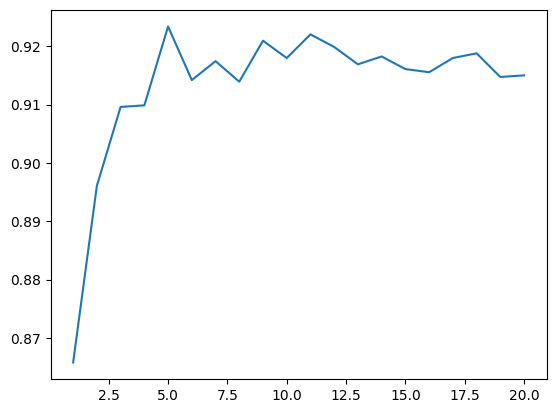

In [18]:
accuracies = [0.8657645459910691, 0.8960757774493691, 0.9096075771464708, 0.9098782130765334, 0.9234100128058974, 0.9142083890221923, 0.9174560208927149, 0.9139377529953426, 0.9209742888546119, 0.9179972929141518, 0.9220568328006987, 0.9198917448762628, 0.9169147489358027, 0.9182679289087391, 0.9161028409520409, 0.9155615689628663, 0.9179972929141518, 0.9188092008979136, 0.9147496609791045, 0.9150202969736917]
import matplotlib.pyplot as plt
epochs = 20
plt.plot(range(1, epochs + 1), accuracies)

In [20]:
def test_one_model(parameters):
    """
    Perform testing for a single trained model.

    Args:
        parameters: An object containing various parameters and configurations.

    Returns:
        all_preds: Tensor containing the predictions for the test dataset.
    """
    test_dataframe = pd.read_csv(path+'/data/tweet_samples_100.csv', sep=",")

    bert_model = transformers.DistilBertModel.from_pretrained(parameters.model_name)
    tokenizer = transformers.AutoTokenizer.from_pretrained(parameters.model_name,
                                                           use_fast=True)

    # Create a test data loader using the test dataset and tokenizer
    test_loader = make_loaders(test_dataframe, tokenizer, mode="test")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the model with the BERT model, number of labels, and dropout rate specified in the `parameters` object
    model = CustomModel(bert_model,
                        parameters.num_labels,
                        dropout=parameters.dropout).to(device)

    model.load_state_dict(torch.load(f"{parameters.model_path}/{parameters.model_save_name}", 
                                     map_location=device))

    model.eval()

    all_preds = None
    with torch.no_grad():
        for batch in tqdm(test_loader):
            # Move the inputs to the device
            batch = {}
            for key, value in batch.items():
                batch[key] = value.to(device)
            
            # Generate predictions using the model
            preds = model(batch)
            
            if all_preds is None:
                all_preds = preds
            else:
                # Concatenate the predictions with the `all_preds` tensor
                all_preds = torch.cat([all_preds, preds], dim=0)

    return all_preds


In [21]:
def test_all_models(parameters):
    """
    Test all models trained on different folds and calculate the mean predictions.

    Args:
        parameters: An object containing the necessary parameters for testing.

    Returns:
        torch.Tensor: The mean predictions of all models.
    """
    # Get the number of folds from the parameters
    num_folds = parameters.n_folds

    all_model_preds = []

    for fold in range(num_folds):
        parameters.model_save_name = f"model_fold_{fold}.pt"
        fold_preds = test_one_model(parameters)
        all_model_preds.append(fold_preds)

    # Stack the predictions along the first dimension to create a tensor of shape (num_folds, ...)
    all_model_preds = torch.stack(all_model_preds, dim=0)

    print(all_model_preds.shape)

    # Calculate the mean predictions along the first dimension
    mean_preds = all_model_preds.mean(0)

    return mean_preds


In [22]:
test_dataframe = pd.read_csv(path+'/data/tweet_samples_100.csv', sep=",")
all_preds = test_all_models(parameters)
predictions = all_preds.argmax(dim=1).cpu().numpy()
true_labels = np.array(test_dataframe["target"].tolist())


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2/2 [00:00<00:00,  4.81it/s]
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_t

torch.Size([5, 100, 2])


In [23]:
np.sum(predictions == true_labels)

78

In [24]:
mismatched_indices = []
for i in range(len(predictions)):
    if predictions[i] != true_labels[i]:
        mismatched_indices.append(i)
mismatched_indices

[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 23, 55, 90]